In [4]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO

In [6]:
import Bio
Bio.__version__

'1.73'

## Read vertebrates mtDNA genomes downloaded from genbank

Query to NCBI nuccore db (2024-05-13):
```
(("Chordata"[Organism] OR chordates[All Fields]) AND complete[All Fields] AND genome[All Fields]) AND (refseq[filter] AND mitochondrion[filter])
```

In [76]:
# read genbank file and print species with 2 OriL
# we exclude such species from analysis

path_to_vertebrates_mtdna = './vertebrates_mtdna.gb'
i = 0
d = []
for rec in SeqIO.parse(path_to_vertebrates_mtdna, 'genbank'):
    i += 1
    n_ori = len([x.type for x in rec.features if x.type == 'rep_origin'])
    d.append(n_ori)
    if n_ori == 2:
        for fea in rec.features:
            if fea.type == 'rep_origin':
                print(i, rec.annotations.get('organism'))
                print(fea)

print('n_ori:', Counter(d))

32 Trachops cirrhosus
type: rep_origin
location: [5182:5214](+)
qualifiers:
    Key: note, Value: ['Replication origin Ligth Chain']

32 Trachops cirrhosus
type: rep_origin
location: [15443:15701](+)
qualifiers:
    Key: note, Value: ['Replication origin Heavy Chain']

202 Triakis semifasciata
type: rep_origin
location: [5289:5319](+)
qualifiers:
    Key: note, Value: ['origin of L-strand replication']

202 Triakis semifasciata
type: rep_origin
location: [15917:16612](+)
qualifiers:
    Key: note, Value: ['origin of H-strand replication']

2233 Pelophylax nigromaculatus
type: rep_origin
location: [936:1000](+)
qualifiers:
    Key: note, Value: ['H-strand origin of replication']

2233 Pelophylax nigromaculatus
type: rep_origin
location: [7794:7825](+)
qualifiers:
    Key: note, Value: ['L-strand origin of replication']

2260 Xenopus laevis
type: rep_origin
location: [1561:1601](+)
qualifiers:
    Key: note, Value: ['H-strand origin of replication (approx)']

2260 Xenopus laevis
type: re

In [5]:
# Eaxtract cytb and oriL locations from genbank files

path_to_vertebrates_mtdna = './vertebrates_mtdna.gb'

data = []
columns = [
    'acc', 'organism', 
    'ori_start', 'ori_end', 'ori_strand', 
    'cytb_start', 'cytb_end', 'cytb_strand',
]
i = 0
for rec in SeqIO.parse(path_to_vertebrates_mtdna, 'genbank'):
    i += 1
    n_ori = len([x.type for x in rec.features if x.type == 'rep_origin'])
    if n_ori > 1:
        continue
    
    acc = rec.id
    organism = rec.annotations.get('organism')
    cytb_start = cytb_end = None
    ori_start = ori_end = None
    cytb_strand = None
    ori_strand = None
    for fea in rec.features:
        if fea.type == 'rep_origin':
            # print(i, fea)
            ori_strand = fea.strand
            ori_start, ori_end = fea.location.nofuzzy_start, fea.location.nofuzzy_end
        # elif fea.type == 'D-loop':
            # print(i, fea)
        elif fea.type == 'CDS':
            if fea.qualifiers.get('gene') and fea.qualifiers.get('gene')[0].lower() == 'cytb' or \
                fea.qualifiers.get('product') and fea.qualifiers.get('product')[0].lower() == 'cytochrome b':
                # print(i, fea.qualifiers.get('gene'))
                cytb_strand = fea.strand
                cytb_start, cytb_end = fea.location.nofuzzy_start, fea.location.nofuzzy_end
    
    data.append(
        [acc, organism, ori_start, ori_end, ori_strand, cytb_start, cytb_end, cytb_strand]
    )

    # if i > 100:
    #     break

In [8]:
# save annotation to file
df_loc = pd.DataFrame(data, columns=columns)
df_loc['ori_len'] = df_loc['ori_end'] - df_loc['ori_start']
df_loc['cytb_len'] = df_loc['cytb_end'] - df_loc['cytb_start']
df_loc['cytb_relative_loc'] = df_loc['cytb_start'] - df_loc['ori_start']
df_loc.to_csv('./cytb_and_oriL_location_genbank_annot.csv', index=False)

## Explore cytb and oriL locations (EDA)

In [9]:
# df_loc = pd.read_csv('./cytb_and_oriL_location_genbank_annot.csv')
df_loc

,acc,organism,ori_start,ori_end,ori_strand,cytb_start,cytb_end,cytb_strand,ori_len,cytb_len,cytb_relative_loc
0,NC_080231.1,Pama pama,NaN,NaN,NaN,14391.0,15532.0,1.0,NaN,1141.0,NaN
1,NC_065807.1,Sciurus anomalus,5184.0,5215.0,1.0,14175.0,15315.0,1.0,31.0,1140.0,8991.0
2,NC_060619.1,Pomatoschistus minutus,NaN,NaN,NaN,14351.0,15492.0,1.0,NaN,1141.0,NaN
3,NC_012825.1,Cynoglossus semilaevis,NaN,NaN,NaN,15426.0,16563.0,1.0,NaN,1137.0,NaN
4,NC_007693.1,Manouria emys,NaN,NaN,NaN,14216.0,15360.0,1.0,NaN,1144.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7827,NC_082237.1,Mesechinus dauuricus,NaN,NaN,NaN,14205.0,15345.0,1.0,NaN,1140.0,NaN
7828,NC_060375.1,Myanophis thanlyinensis,6111.0,6147.0,1.0,15001.0,16118.0,1.0,36.0,1117.0,8890.0
7829,NC_027169.1,Sinocyclocheilus anshuiensis,NaN,NaN,NaN,15334.0,16475.0,1.0,NaN,1141.0,NaN
7830,NC_027168.1,Sinocyclocheilus rhinocerous,NaN,NaN,NaN,15305.0,16446.0,1.0,NaN,1141.0,NaN


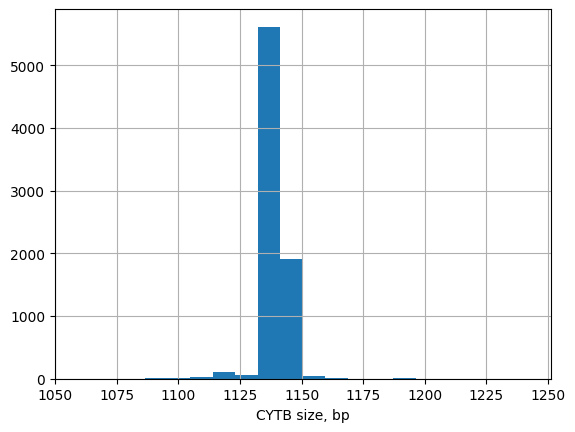

In [10]:
#plot CYTB size distribution
df_loc.cytb_len.hist(bins=20).set_xlabel('CYTB size, bp');

In [11]:
# check strand that contain CYTB gene
df_loc.cytb_strand.value_counts()

cytb_strand
 1.0    7807
-1.0      21
Name: count, dtype: int64

In [12]:
# check OriL size statistics
# there are some outliers
df_loc['ori_len'].describe()

count    2203.000000
mean       44.972764
std       161.106286
min        11.000000
25%        31.000000
50%        34.000000
75%        36.000000
max      3423.000000
Name: ori_len, dtype: float64

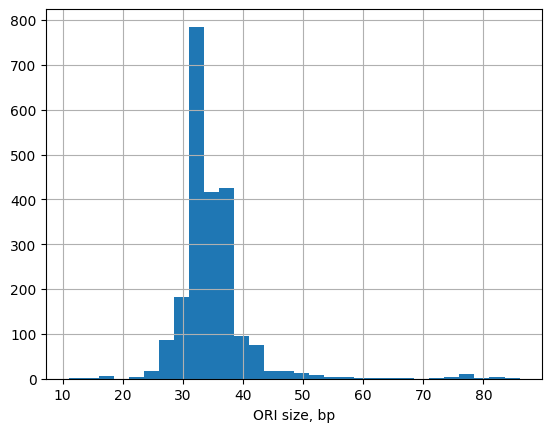

In [13]:
# show distribution of Ori length without outliers
df_loc.ori_len[df_loc.ori_len < 100].hist(bins=30).set_xlabel('ORI size, bp');

In [14]:
# filter out outliers by Ori size, Cytb strand and species with missing ori annotation
df_loc_with_ori = df_loc[
    (~df_loc.ori_start.isna()) & 
    (df_loc.cytb_strand == 1) &
    (df_loc.ori_len < 100)
]
df_loc_with_ori

,acc,organism,ori_start,ori_end,ori_strand,cytb_start,cytb_end,cytb_strand,ori_len,cytb_len,cytb_relative_loc
1,NC_065807.1,Sciurus anomalus,5184.0,5215.0,1.0,14175.0,15315.0,1.0,31.0,1140.0,8991.0
9,NC_063962.1,Trimerodytes annularis,6392.0,6430.0,1.0,15290.0,16407.0,1.0,38.0,1117.0,8898.0
12,NC_057198.1,Hylarana latouchii,5362.0,5388.0,-1.0,14224.0,15364.0,1.0,26.0,1140.0,8862.0
14,NC_056269.1,Quasipaa exilispinosa,5430.0,5456.0,1.0,14341.0,15487.0,1.0,26.0,1146.0,8911.0
19,NC_008450.1,Neofelis nebulosa,6077.0,6109.0,1.0,15065.0,16205.0,1.0,32.0,1140.0,8988.0
...,...,...,...,...,...,...,...,...,...,...,...
7815,NC_000893.1,Amblyraja radiata,5304.0,5341.0,-1.0,14364.0,15507.0,1.0,37.0,1143.0,9060.0
7816,NC_083923.1,Rhogeessa genowaysi,5158.0,5193.0,-1.0,14159.0,15299.0,1.0,35.0,1140.0,9001.0
7817,NC_083922.1,Rhogeessa mira,5158.0,5193.0,-1.0,14159.0,15299.0,1.0,35.0,1140.0,9001.0
7823,NC_060316.1,Micromys erythrotis,5153.0,5185.0,-1.0,14114.0,15258.0,1.0,32.0,1144.0,8961.0


In [15]:
# check ori strand
df_loc_with_ori.ori_strand.value_counts()

ori_strand
 1.0    1556
-1.0     623
Name: count, dtype: int64

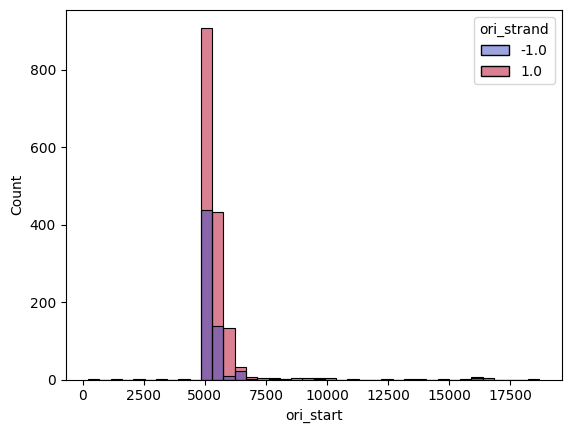

In [11]:
# check ori start position distribution
sns.histplot(data=df_loc_with_ori, x='ori_start', hue='ori_strand', bins=40, palette='coolwarm');

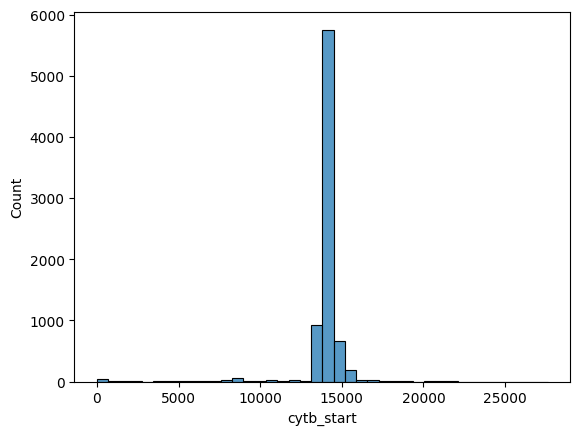

In [16]:
# check cytb start position distribution
sns.histplot(data=df_loc, x='cytb_start', bins=40);

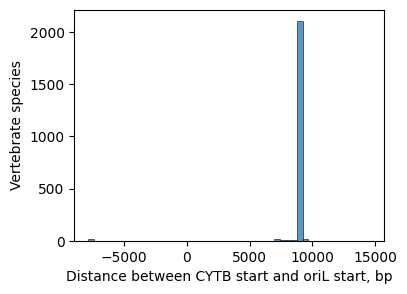

In [15]:
# substract Ori start position from Cytb start position (relative Cytb distance)
# to estimate distance between them

plt.figure(figsize=(4, 3))
ax = sns.histplot(data=df_loc_with_ori, x='cytb_relative_loc', bins=50)
ax.set_xlabel('Distance between CYTB start and oriL start, bp')
ax.set_ylabel('Vertebrate species');

In [16]:
# check stats of this distribution
# again there are outliers, but common case shown on plot above
df_loc_with_ori.cytb_relative_loc.describe()

count     2179.000000
mean      8881.270307
std       1376.819691
min      -7834.000000
25%       8987.000000
50%       9001.000000
75%       9065.000000
max      14605.000000
Name: cytb_relative_loc, dtype: float64

In [17]:
# cytb relative location quantiles
df_loc_with_ori.cytb_relative_loc.quantile([0.025, 0.5, 0.975])

0.025    8843.60
0.500    9001.00
0.975    9110.55
Name: cytb_relative_loc, dtype: float64

## Intersect with spectra dataset species

In [19]:
# load main spectra dataset
spectra = pd.read_csv('../../1data_derivation/dataset/MutSpecVertebrates192.csv.gz')
spectra = spectra[spectra.Gene == 'Cytb']
spectra

,Gene,Class,Species,Mut,Observed,Expected,MutSpec
39552,Cytb,Mammalia,Tarsius_dentatus,A[A>C]A,NaN,0.000000,0.000000
39553,Cytb,Mammalia,Tarsius_dentatus,A[A>C]C,NaN,0.000000,0.000000
39554,Cytb,Mammalia,Tarsius_dentatus,A[A>C]G,NaN,0.000000,0.000000
39555,Cytb,Mammalia,Tarsius_dentatus,A[A>C]T,NaN,0.000000,0.000000
39556,Cytb,Mammalia,Tarsius_dentatus,C[A>C]A,NaN,11.950000,0.000000
...,...,...,...,...,...,...,...
365371,Cytb,Mammalia,Trinomys_dimidiatus,G[T>G]T,0.792849,0.955556,0.051957
365372,Cytb,Mammalia,Trinomys_dimidiatus,T[T>G]A,NaN,2.822222,0.000000
365373,Cytb,Mammalia,Trinomys_dimidiatus,T[T>G]C,NaN,2.933333,0.000000
365374,Cytb,Mammalia,Trinomys_dimidiatus,T[T>G]G,NaN,0.066667,0.000000


In [20]:
species = spectra.Species.str.replace('_', ' ').unique()
len(species), species[:4]

(1697,
 array(['Tarsius dentatus', 'Montivipera xanthina',
        'Peromyscus maniculatus', 'Acentrogobius janthinopterus'],
       dtype=object))

In [22]:
df_loc_with_ori[df_loc_with_ori.organism.isin(species)]

,acc,organism,ori_start,ori_end,ori_strand,cytb_start,cytb_end,cytb_strand,ori_len,cytb_len,cytb_relative_loc
1,NC_065807.1,Sciurus anomalus,5184.0,5215.0,1.0,14175.0,15315.0,1.0,31.0,1140.0,8991.0
20,NC_082320.1,Rhogeessa aeneus,5158.0,5189.0,1.0,14158.0,15298.0,1.0,31.0,1140.0,9000.0
30,NC_001665.2,Rattus norvegicus,5152.0,5184.0,1.0,14135.0,15278.0,1.0,32.0,1143.0,8983.0
50,NC_028088.1,Cyprinodon variegatus,5296.0,5332.0,1.0,14385.0,15525.0,1.0,36.0,1140.0,9089.0
57,AC_000022.2,Rattus norvegicus,5139.0,5170.0,1.0,14123.0,15266.0,1.0,31.0,1143.0,8984.0
...,...,...,...,...,...,...,...,...,...,...,...
7789,NC_002763.1,Cebus albifrons,5152.0,5188.0,-1.0,14171.0,15308.0,1.0,36.0,1137.0,9019.0
7803,NC_000861.1,Salvelinus alpinus,6295.0,6331.0,1.0,15377.0,16518.0,1.0,36.0,1141.0,9082.0
7807,NC_001992.1,Papio hamadryas,5158.0,5192.0,1.0,14171.0,15312.0,1.0,34.0,1141.0,9013.0
7808,NC_001821.1,Dasypus novemcinctus,5184.0,5218.0,1.0,14170.0,15310.0,1.0,34.0,1140.0,8986.0


Only 389 genomes from spectra dataset have oriL labels, need to annotate genomes manually